# Code generation with RAG and self-correction
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/

AlphaCodium은 제어 흐름(control flow)을 활용한 코드 생성 방식을 제안했습니다.

핵심 아이디어: 코딩 문제에 대한 정답을 반복적으로 구성하는 것입니다.(https://x.com/karpathy/status/1748043513156272416?s=20)

AlphaCodium( https://github.com/Codium-ai/AlphaCodium )은 특정 문제에 대해 공개 테스트와 AI가 생성한 테스트를 사용해 정답을 반복적으로 테스트하고 개선합니다.

다음은 LangGraph를 사용하여 이러한 아이디어 중 일부를 처음부터 구현하는 과정입니다:

1. 사용자에 의해 지정된 문서 집합으로 시작합니다.
2. 이 문서를 장문 컨텍스트 LLM(long context LLM)을 통해 입력받고, 이를 기반으로 RAG(Retrieval-Augmented Generation)를 수행하여 질문에 답변합니다.
3. 도구(tool)를 호출하여 구조화된 출력(structured output)을 생성합니다.
4. 사용자에게 솔루션을 반환하기 전에 두 가지 단위 테스트(임포트 확인 및 코드 실행 테스트)를 수행합니다.

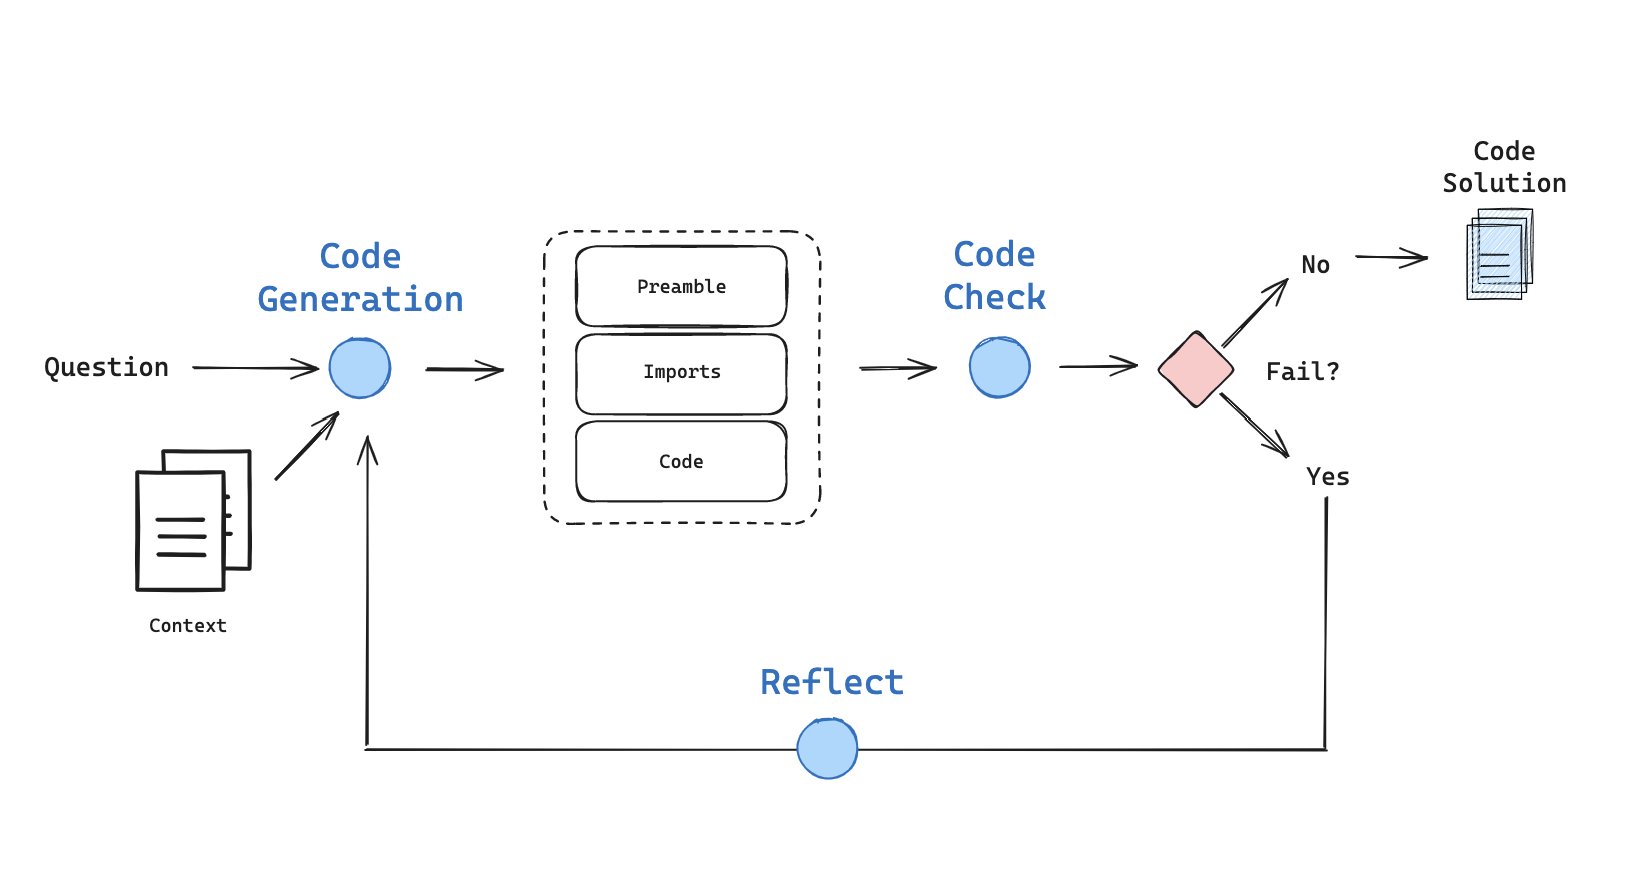

# 라이브러리 설치

In [ ]:
!pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community chromadb wikipedia bs4 langchain_community

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# API Key 설정

In [ ]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Code generation with RAG and self-correction - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "여러분의_LANGCHAIN_API_KEY"

In [ ]:
unique_id

'14519ab4'

In [ ]:
os.environ["OPENAI_API_KEY"] = "여러분의_OPENAI_API_KEY"

# Docs

예시로 LangChain Expression Language (LCEL) 문서( https://python.langchain.com/docs/concepts/#langchain-expression-language-lcel )를 불러옵니다.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

# LCEL 관련 문서 URL 20개 (공식 문서에서 수집한 주요 개념 페이지들)
urls = [
    "https://python.langchain.com/docs/concepts/lcel/",
    "https://python.langchain.com/docs/concepts/runnables/",
    "https://python.langchain.com/docs/concepts/structured_outputs/",
    "https://python.langchain.com/docs/concepts/tool_calling/",
    "https://python.langchain.com/docs/concepts/tools/",
    "https://python.langchain.com/docs/concepts/callbacks/",
    "https://python.langchain.com/docs/concepts/messages/",
    "https://python.langchain.com/docs/concepts/chat_models/",
    "https://python.langchain.com/docs/concepts/chat_history/",
    "https://python.langchain.com/docs/concepts/text_splitters/",
    "https://python.langchain.com/docs/concepts/output_parsers/",
    "https://python.langchain.com/docs/concepts/prompt_templates/",
    "https://python.langchain.com/docs/concepts/agents/",
    "https://python.langchain.com/docs/concepts/evaluation/",
    "https://python.langchain.com/docs/concepts/testing/",
    "https://python.langchain.com/docs/concepts/tracing/",
    "https://python.langchain.com/docs/concepts/embedding_models/",
    "https://python.langchain.com/docs/concepts/vectorstores/",
    "https://python.langchain.com/docs/concepts/retrievers/",
    "https://python.langchain.com/docs/concepts/retrieval/"
]

# WebBaseLoader를 사용해 문서 로드
loader = WebBaseLoader(urls)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [ ]:
d_sorted

[Document(metadata={'source': 'https://python.langchain.com/docs/concepts/agents/', 'title': 'Agents | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain', 'description': "By themselves, language models can't take actions - they just output text. Agents are systems that take a high-level task and use an LLM as a reasoning engine to decide what actions to take and execute those actions.", 'language': 'en'}, page_content='\n\n\n\n\nAgents | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1\uf8ffüí¨SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild

In [ ]:
len(d_sorted)

20

In [ ]:
d_reversed

[Document(metadata={'source': 'https://python.langchain.com/docs/concepts/vectorstores/', 'title': 'Vector stores | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain', 'description': '* Embeddings', 'language': 'en'}, page_content='\n\n\n\n\nVector stores | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1\uf8ffüí¨SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools

In [ ]:
print(concatenated_content)






Vector stores | ü¶úÔ∏èüîó LangChain






Skip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1üí¨SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model responsesHow to add default

# LLMs

## Code solution

먼저, OpenAI 함수 호출(Function Calling) 방식으로 사용해보겠습니다.

OpenAI GPT 모델을 사용하여 code_gen_chain을 생성하고, 여기서 테스트해볼 예정입니다.

**LangChain에서 Pydantic 사용하기**

이 노트북은 Pydantic v2의 BaseModel을 사용하며, 이를 위해 langchain-core >= 0.3 버전이 필요합니다.
langchain-core < 0.3 버전을 사용할 경우, Pydantic v1과 v2의 BaseModel이 혼합되어 오류가 발생할 수 있습니다.










In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user
    question based on the above provided documentation. Ensure any code you provide can be executed \n
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)

In [ ]:
# 당신은 LCEL, LangChain expression language에 전문성을 가진 코딩 어시스턴트입니다.
# 다음은 LCEL 전체 문서입니다:
# {context}
# 위 문서를 기반으로 사용자 질문에 답하세요.
# 제공하는 모든 코드가 실행 가능하도록 필요한 import와 변수들이 모두 정의되어 있어야 합니다.
# 답변은 코드 솔루션에 대한 설명, import 목록, 작동 가능한 코드 블록의 순서로 구성하세요.
# 다음은 사용자 질문입니다:

In [ ]:
question = "LCEL을 이용해서 RAG 체인을 어떻게 구축하나요?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='RAG (Retrieval-Augmented Generation) 체인은 정보 검색과 생성 모델을 결합하여 더 정확하고 관련성 높은 응답을 생성하는 방법입니다. LCEL (LangChain Expression Language)을 사용하여 RAG 체인을 구축하는 방법은 다음과 같습니다. 이 예제에서는 벡터 저장소에서 문서를 검색하고, 검색된 문서를 기반으로 LLM (대형 언어 모델)을 사용하여 응답을 생성하는 체인을 구성합니다.', imports='from langchain_core.vectorstores import InMemoryVectorStore\nfrom langchain_core.embeddings import OpenAIEmbeddings\nfrom langchain_core.chains import RetrievalQA\nfrom langchain_core.llms import OpenAI\nfrom langchain_core.prompts import PromptTemplate\nfrom langchain_core.documents import Document', code='# 1. 임베딩 모델 초기화\nembedding_model = OpenAIEmbeddings()\n\n# 2. 벡터 저장소 초기화\nvector_store = InMemoryVectorStore(embedding=embedding_model)\n\n# 3. 문서 추가\ndocuments = [\n    Document(page_content="이것은 첫 번째 문서입니다.", metadata={"source": "source1"}),\n    Document(page_content="이것은 두 번째 문서입니다.", metadata={"source": "source2"})\n]\nvector_store.add_documents(documents)\n\n# 4. LLM 초기화\nllm = OpenAI(model="gpt-3.5-turbo")\n\n# 5. 프

In [ ]:
print(solution.prefix)

RAG (Retrieval-Augmented Generation) 체인은 정보 검색과 생성 모델을 결합하여 더 정확하고 관련성 높은 응답을 생성하는 방법입니다. LCEL (LangChain Expression Language)을 사용하여 RAG 체인을 구축하는 방법은 다음과 같습니다. 이 예제에서는 벡터 저장소에서 문서를 검색하고, 검색된 문서를 기반으로 LLM (대형 언어 모델)을 사용하여 응답을 생성하는 체인을 구성합니다.


In [ ]:
print(solution.imports)

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.embeddings import OpenAIEmbeddings
from langchain_core.chains import RetrievalQA
from langchain_core.llms import OpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document


In [ ]:
print(solution.code)

# 1. 임베딩 모델 초기화
embedding_model = OpenAIEmbeddings()

# 2. 벡터 저장소 초기화
vector_store = InMemoryVectorStore(embedding=embedding_model)

# 3. 문서 추가
documents = [
    Document(page_content="이것은 첫 번째 문서입니다.", metadata={"source": "source1"}),
    Document(page_content="이것은 두 번째 문서입니다.", metadata={"source": "source2"})
]
vector_store.add_documents(documents)

# 4. LLM 초기화
llm = OpenAI(model="gpt-3.5-turbo")

# 5. 프롬프트 템플릿 정의
prompt_template = PromptTemplate.from_template("다음 문서에 대한 질문에 답하십시오: {context}")

# 6. RAG 체인 생성
rag_chain = RetrievalQA(llm=llm, retriever=vector_store.as_retriever(), prompt=prompt_template)

# 7. 질문에 대한 응답 생성
query = "첫 번째 문서에 대해 설명해 주세요."
response = rag_chain.invoke(query)
print(response)


# State

우리의 상태(state)는 코드 생성과 관련된 키들(errors, question, code generation)을 포함하는 딕셔너리(dict)입니다.

In [ ]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

# Graph

우리의 그래프는 위 그림에 나타난 논리적 흐름을 구성합니다.

In [ ]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        full_code = f"""{imports}

        {code}
        """
        # 실행 컨텍스트를 명시적으로 분리
        exec_globals = {}
        exec(full_code, exec_globals)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

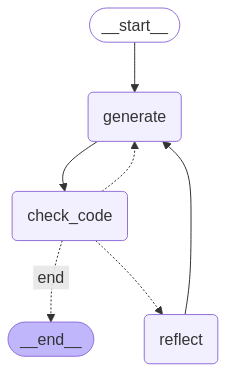

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"

solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
text='Tell me a joke about cats'
---NO CODE TEST FAILURES---
---DECISION: FINISH---


In [ ]:
solution["generation"]

code(prefix="To directly pass a string to a runnable and use it to construct the input for your prompt, you can utilize the `RunnableLambda` class in LangChain. This allows you to define a function that takes a string input and constructs the necessary prompt format. You can then invoke this runnable with the string input. Here's how you can do it:", imports='from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import PromptTemplate', code='# Define a function that constructs the prompt\ndef construct_prompt(input_string: str) -> str:\n    prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n    return prompt_template.invoke({\'topic\': input_string})\n\n# Create a RunnableLambda from the function\nrunnable = RunnableLambda(construct_prompt)\n\n# Now you can invoke the runnable with a string input\nresult = runnable.invoke("cats")\nprint(result)  # This will print the constructed prompt based on the input.')

In [ ]:
solution["error"]

'no'

In [ ]:
solution["messages"]

[('user',
  'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
 ('assistant',
  'To directly pass a string to a runnable and use it to construct the input for your prompt, you can utilize the `RunnableLambda` class in LangChain. This allows you to define a function that takes a string input and constructs the necessary prompt format. You can then invoke this runnable with the string input. Here\'s how you can do it: \n Imports: from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import PromptTemplate \n Code: # Define a function that constructs the prompt\ndef construct_prompt(input_string: str) -> str:\n    prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n    return prompt_template.invoke({\'topic\': input_string})\n\n# Create a RunnableLambda from the function\nrunnable = RunnableLambda(construct_prompt)\n\n# Now you can invoke the runnable with a string input\nresult =

In [ ]:
solution["iterations"]

1

# 생성해준 코드 Imports & Code 분석

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
# Define a prompt template
prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")

# Create a runnable that constructs the prompt
runnable = RunnableLambda(lambda topic: prompt_template.invoke({'topic': topic}))

# Invoke the runnable with a string input
result = runnable.invoke('cats')

# Print the constructed prompt
print(result)

text='Tell me a joke about cats'


In [ ]:
question = "문자열을 runnable에 직접 전달해서 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?"

solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
content='Hello! I’m just a computer program, so I don’t have feelings, but I’m here and ready to help you. How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BOQJEnQUUQcIqCpw2Xa8SnSwLS6PI', 'finish_reason': 'stop', 'logprobs': None} id='run-b6c14223-3cd6-4cdf-8ed5-12447f2846d9-0' usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
---NO CODE TEST FAILURES---
---DECISION: FINISH---


In [ ]:
solution["generation"]

code(prefix="To pass a string directly to a runnable and construct the necessary input for a prompt, you can use the `invoke` method of the runnable. This method allows you to provide a string input, which will be automatically converted into the appropriate message format required by the chat model. Here's how you can do it:", imports='from langchain_core.messages import HumanMessage\nfrom langchain_openai import ChatOpenAI', code='# Initialize the chat model\nmodel = ChatOpenAI(model="gpt-4o")\n\n# Directly invoke the model with a string input\nresponse = model.invoke("Hello, how are you?")\n\n# Print the response from the model\nprint(response)')

In [ ]:
solution["error"]

'no'

In [ ]:
solution["messages"]

[('user', '문자열을 runnable에 직접 전달해서 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?'),
 ('assistant',
  'To pass a string directly to a runnable and construct the necessary input for a prompt, you can use the `invoke` method of the runnable. This method allows you to provide a string input, which will be automatically converted into the appropriate message format required by the chat model. Here\'s how you can do it: \n Imports: from langchain_core.messages import HumanMessage\nfrom langchain_openai import ChatOpenAI \n Code: # Initialize the chat model\nmodel = ChatOpenAI(model="gpt-4o")\n\n# Directly invoke the model with a string input\nresponse = model.invoke("Hello, how are you?")\n\n# Print the response from the model\nprint(response)')]

In [ ]:
solution["iterations"]

1

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

In [ ]:
# Define a simple runnable that takes a string input and returns a formatted message
runnable = RunnableLambda(lambda input_str: HumanMessage(content=input_str))

# Now, you can invoke the runnable with a string input
input_string = "Hello, how are you?"
formatted_message = runnable.invoke(input_string)

# If you want to pass this to a chat model
model = ChatOpenAI(model="gpt-4o")
response = model.invoke([formatted_message])

# Print the response from the model
print(response)

content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BOQJFMDcS2ZoOD9Tm5FwZ0B9V8Si7', 'finish_reason': 'stop', 'logprobs': None} id='run-4ad9d934-e16b-4f27-bcaa-446738fde697-0' usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


# Eval

다음은 LCEL 질문들로 구성된 공개 데이터셋 (https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) 입니다.

이 데이터셋은 lcel-teacher-eval이라는 이름으로 저장해두었습니다.

CSV 파일은 여기( https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv )에서도 확인할 수 있습니다.

In [ ]:
import langsmith

client = langsmith.Client()

In [ ]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

커스텀 평가 (Custom evals)

In [ ]:
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}


def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        #exec(imports + "\n" + code)
        full_code = f"""{imports}

        {code}
        """
        # 실행 컨텍스트를 명시적으로 분리
        exec_globals = {}
        exec(full_code, exec_globals)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

LangGraph와 컨텍스트 스터핑(Context Stuffing)을 비교하세요.

In [ ]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    return {"imports": solution.imports, "code": solution.code}


def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke(
        {"messages": [("user", example["question"])], "iterations": 0, "error": ""}
    )
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [ ]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "lcel-teacher-eval"

In [ ]:
# Run base case
try:
    experiment_results_ = evaluate(
        predict_base_case,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-without-langgraph-{expt_llm}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
        },
    )
except:
    print("Please setup LangSmith")

View the evaluation results for experiment: 'test-without-langgraph-gpt-4o-mini-82b9afcd' at:
https://smith.langchain.com/o/2da4358c-aaa8-5f93-b4af-fa2d78b96bd8/datasets/3d1682fd-0c76-4193-99e3-1f9bca0b6bd9/compare?selectedSessions=23a5a320-1249-4524-a079-87dd09b46680




0it [00:00, ?it/s]

itemgetter: What is LCEL?
lambda: What is LCEL?
get: What is LCEL?
('content', 'The capital of France is Paris.')
('additional_kwargs', {'refusal': None})
('response_metadata', {'token_usage': {'completion_tokens': 8, 'prompt_tokens': 24, 'total_tokens': 32, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BOQMNg7RnlKbNlec1cqmMAUh747oJ', 'finish_reason': 'stop', 'logprobs': None})
('type', 'ai')
('name', None)
('id', 'run-fb038643-e0d0-434d-b363-73c8ffd87581-0')
('example', False)
('tool_calls', [])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 24, 'output_tokens': 8, 'total_tokens': 32, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
{'a': 1, 'b': 2, 'c': 3}
{'chain_one_output': 'Out

In [ ]:
# Run with langgraph
try:
    experiment_results = evaluate(
        predict_langgraph,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-with-langgraph-{expt_llm}-{flag}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
            "feedback": flag,
        },
    )
except:
    print("Please setup LangSmith")

View the evaluation results for experiment: 'test-with-langgraph-gpt-4o-mini-do not reflect-98be5059' at:
https://smith.langchain.com/o/2da4358c-aaa8-5f93-b4af-fa2d78b96bd8/datasets/3d1682fd-0c76-4193-99e3-1f9bca0b6bd9/compare?selectedSessions=7a335a68-2015-40b9-a3bc-40a8df047eff




0it [00:00, ?it/s]

---GENERATING CODE SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
Using itemgetter: What is the capital of France?
Using lambda: What is the capital of France?
Using get method: What is the capital of F

결과:


*   LangGraph는 기본 방식보다 더 나은 성능을 보였습니다:**재시도 루프(re-try loop)를 추가하면 성능이 향상**되었습니다.

In [ ]:
from langchain_core.runnables import RunnableSequence
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
# Define a prompt template
prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")

# Initialize the chat model
model = ChatOpenAI(model="gpt-4", temperature=0)

# Create a chain using LCEL
chain = RunnableSequence([prompt_template, model])

# Get the input schema of the chain
input_schema = chain.get_input_schema()

# Print the input schema
print(input_schema)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'list'>

In [ ]:
# Define a prompt template
prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")

# Initialize the chat model
model = ChatOpenAI(model="gpt-4", temperature=0)

# Create a chain using LCEL
chain = RunnableSequence(prompt_template | model)

# Get the input schema of the chain
input_schema = chain.get_input_schema()

# Print the input schema
print(input_schema)

<class 'langchain_core.utils.pydantic.PromptInput'>
